# Data Visualizations
This notebook generates the figures used in Appendix A of the case study. It provides visual evidence for the methodological decisions and clearly interpretable representations of the results.

*Note: all markdown cells are numbered by their respective figure numbers in the case study, and therefore might appear without linear order.*

In [18]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import missingno as msno
import seaborn as sns
from prince import FAMD
from math import pi
from sklearn.feature_selection import mutual_info_classif
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
import gower
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE

In [19]:
#Palettes
sns.set_theme(style="whitegrid", context="notebook")
PALETTE = "viridis"
PALETTE_BINARY = {"Yes": "#2ecc71", "No": "#e74c3c", "Maybe": "#f39c12", "Unknown": "#95a5a6"}
PALETTE_GENDER = {'Male': '#3498db', 'Female': '#e74c3c', 'Non-binary': '#9b59b6'}
PALETTE_REMOTE = {'Never': '#e74c3c', 'Sometimes': '#f1c40f', 'Always': '#2ecc71'}
PALETTE_SIZE = {'1-5': '#2c7da0', '6-25': '#468faf', '26-100': '#61a5c2', '100-500': '#89c2d9', '500-1000': '#a9d6e5', 'More than 1000': '#d1eaf5'}
PALETTE_TECH = {'Yes': '#2ecc71', 'No': '#e74c3c'}

In [20]:
#Visualization mappings
REMOTE_MAPPING = {0: 'Never', 1: 'Sometimes', 2: 'Always'}
SIZE_MAPPING = {0: '1-5', 1: '6-25', 2: '26-100', 3: '100-500', 4: '500-1000', 5: 'More than 1000'}
MH_MAPPING = {0: 'No', 1: 'Maybe', 2: 'Yes'}
COUNTRY_MAPPING = {
    'United States of America': 'USA',
    'United Kingdom': 'UK',
    'Other': 'Other',
    'Netherlands': 'NL',
    'Germany': 'DE',
    'Canada': 'CA',
    'Australia': 'AU',
    'Sweden': 'SE'
}

In [21]:
#Custom savefig
def save_fig(title):
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    filename = title.lower().replace(" ", "_").replace("/", "-") + ".png"
    plt.savefig(f"../figures/{filename}", dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

In [22]:
#Load data
try:
    df_raw = pd.read_csv('../data/raw/mental-heath-in-tech-2016_20161114.csv')
    df_struct = pd.read_csv('../data/processed/df_struct.csv')
    df_clean = pd.read_csv('../data/processed/df_cat.csv', keep_default_na=False, na_values='')
    df_final = pd.read_csv('../data/processed/df_clustered.csv', keep_default_na=False, na_values='')
except FileNotFoundError as e:
    print(str(e))

In [23]:
df_clean['Cluster'] = df_final['Cluster']

## Figure 1
**Demographic Distribution of Survey Participants**

*Shown in section 2.1.1.*

Saved: demographics.png


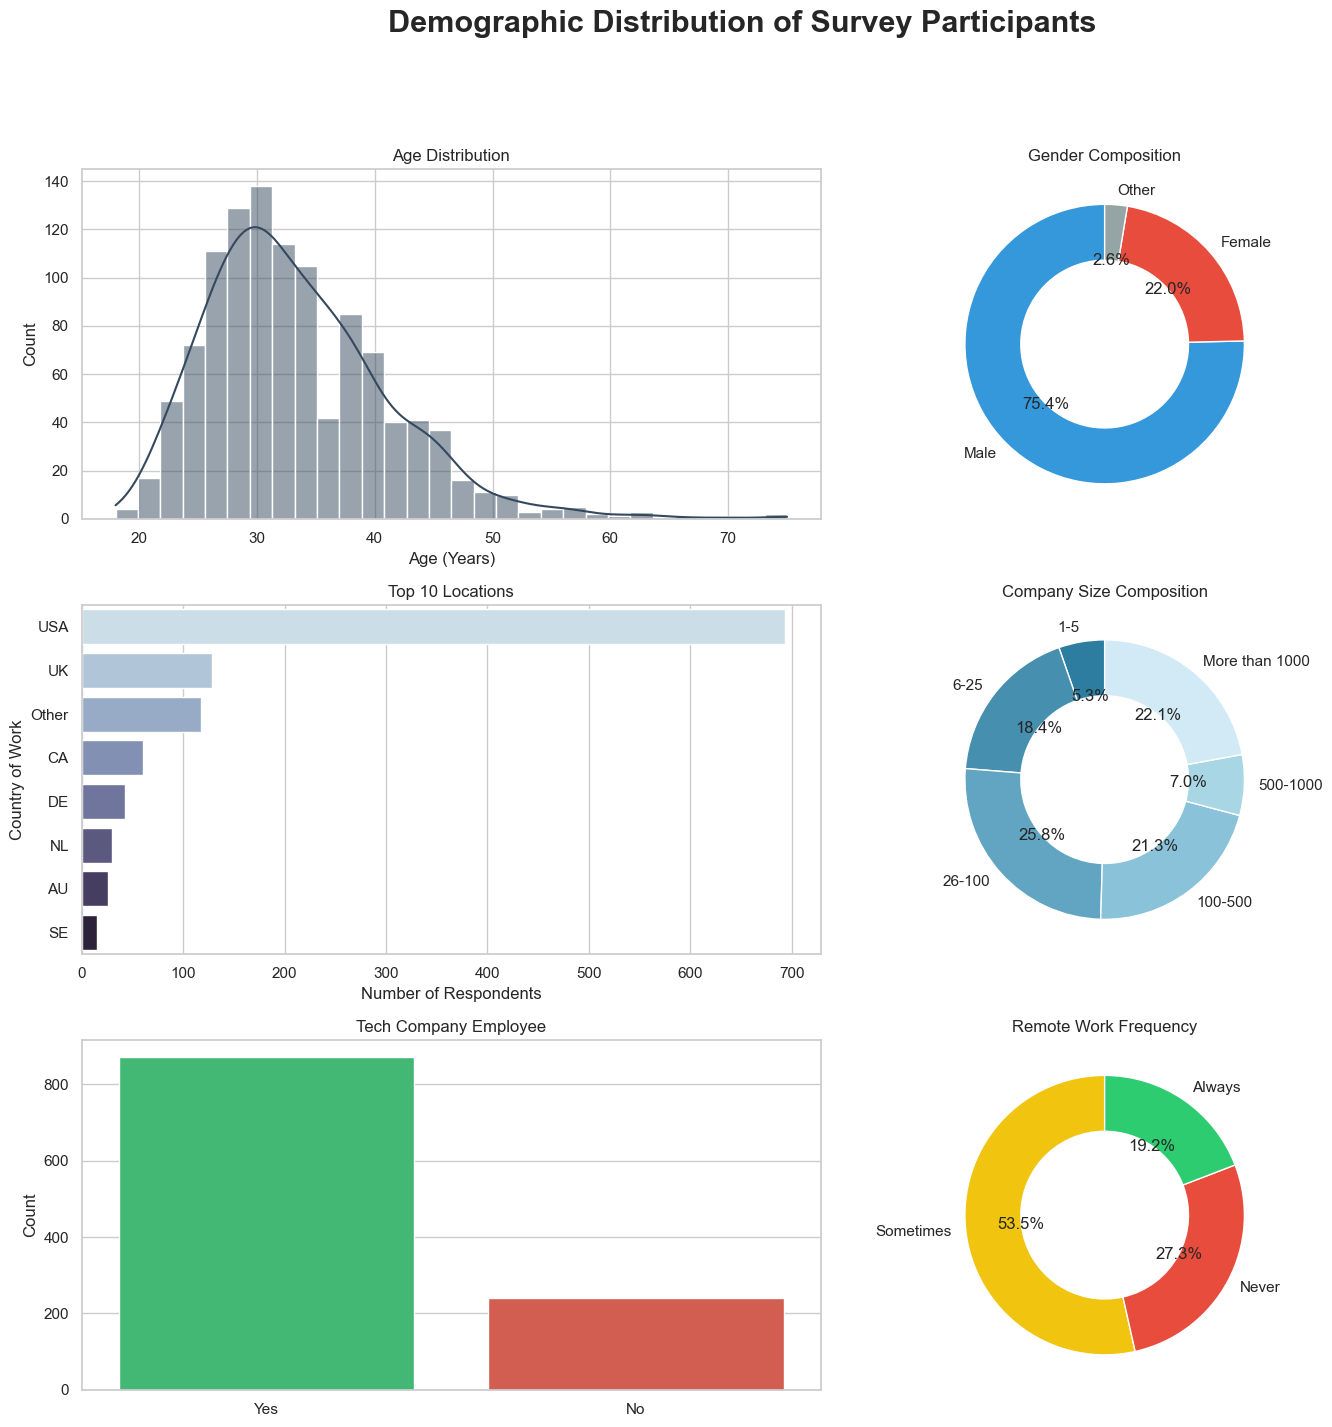

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.suptitle('Demographic Distribution of Survey Participants', fontsize=22, weight='bold', y=0.95)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 1. Age
if df_clean['age'].max() <= 1.0:
    df_clean['age'] = df_clean['age'].apply(lambda x: x * (75 - 18) + 18)
    df_clean['age'] = df_clean['age'].round().astype(int)
sns.histplot(df_clean['age'], kde=True, ax=axes[0, 0], color='#34495e')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age (Years)')

# 2. Gender
gender_counts = df_clean['gender'].value_counts()
axes[0, 1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=[PALETTE_GENDER.get(x, '#95a5a6') for x in gender_counts.index], startangle=90, wedgeprops={'width': 0.4})
axes[0, 1].set_title('Gender Composition')

# 3. Country
top_countries = df_clean['country_work'].value_counts().head(10)
top_countries = top_countries.rename(index=COUNTRY_MAPPING)
sns.barplot(x=top_countries.values, y=top_countries.index, ax=axes[1, 0], palette="ch:s=.25,rot=-.25")
axes[1, 0].set_title('Top 10 Locations')
axes[1, 0].set_xlabel('Number of Respondents')
axes[1, 0].set_ylabel('Country of Work')

# 4. Company Size
size_counts = df_clean['company_size'].value_counts().rename(index=SIZE_MAPPING)
size_counts = size_counts.reindex(SIZE_MAPPING.values()).dropna()
axes[1, 1].pie(size_counts, labels=size_counts.index, autopct='%1.1f%%', colors=[PALETTE_SIZE.get(x, '#95a5a6') for x in size_counts.index], startangle=90, wedgeprops={'width': 0.4})
axes[1, 1].set_title('Company Size Composition')
axes[1, 1].set_xlabel('')

# 5. Tech Company
sns.countplot(x='is_tech_company', data=df_clean, ax=axes[2, 0], palette=PALETTE_TECH)
axes[2, 0].set_title('Tech Company Employee')
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylabel('Count')

# 6. Remote Work
remote_counts = df_clean['remote'].value_counts().rename(index=REMOTE_MAPPING)
axes[2, 1].pie(remote_counts, labels=remote_counts.index, autopct='%1.1f%%', colors=[PALETTE_REMOTE.get(x, '#95a5a6') for x in remote_counts.index], startangle=90, wedgeprops={'width': 0.4})
axes[2, 1].set_title('Remote Work Frequency')
axes[2, 1].set_xlabel('')

plt.tight_layout()
save_fig('demographics')
plt.show()

## Figure 2
**Global Mental Health Status Distribution**

*Shown in section 3.1.*

Saved: global_mh.png


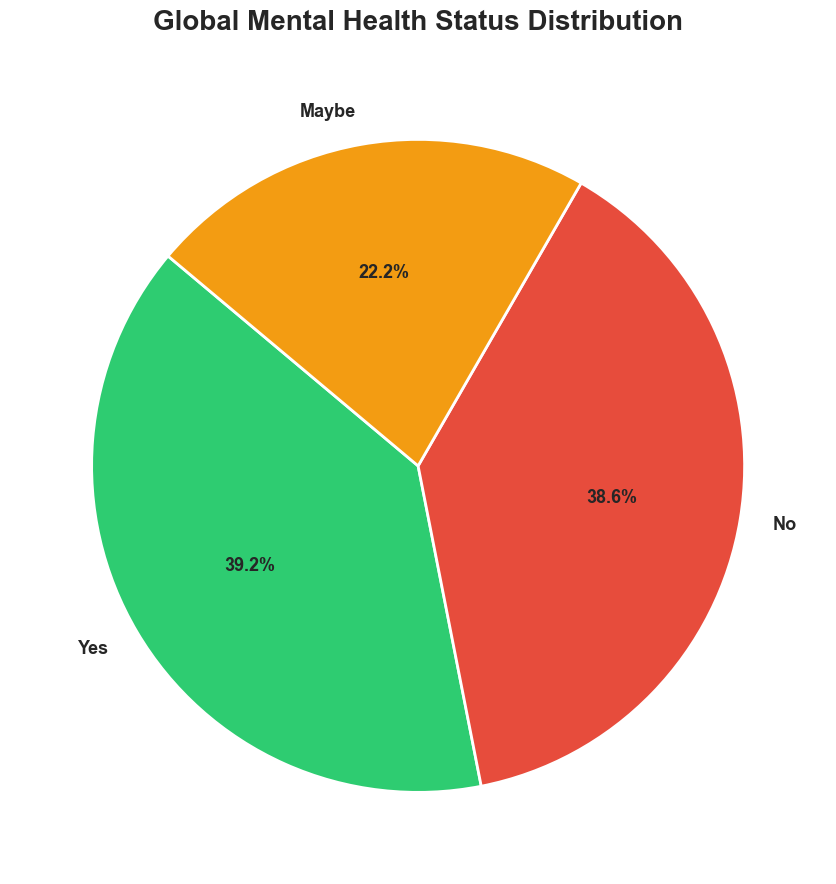

In [25]:
mh_counts = df_clean['curr_mh_disorder'].value_counts()
mh_counts = mh_counts.rename(index=MH_MAPPING)
colors = [PALETTE_BINARY.get(label, "#95a5a6") for label in mh_counts.index]

plt.figure(figsize=(10, 10))
plt.pie(
    mh_counts, 
    labels=mh_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True},
    textprops={'fontsize': 13, 'fontweight': 'bold'}
)

plt.title('Global Mental Health Status Distribution', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
save_fig("global_mh")
plt.show()

## Figure A1
**Missing Value Pattern**

*Referenced in section 2.1.2.*

Saved: missing.png


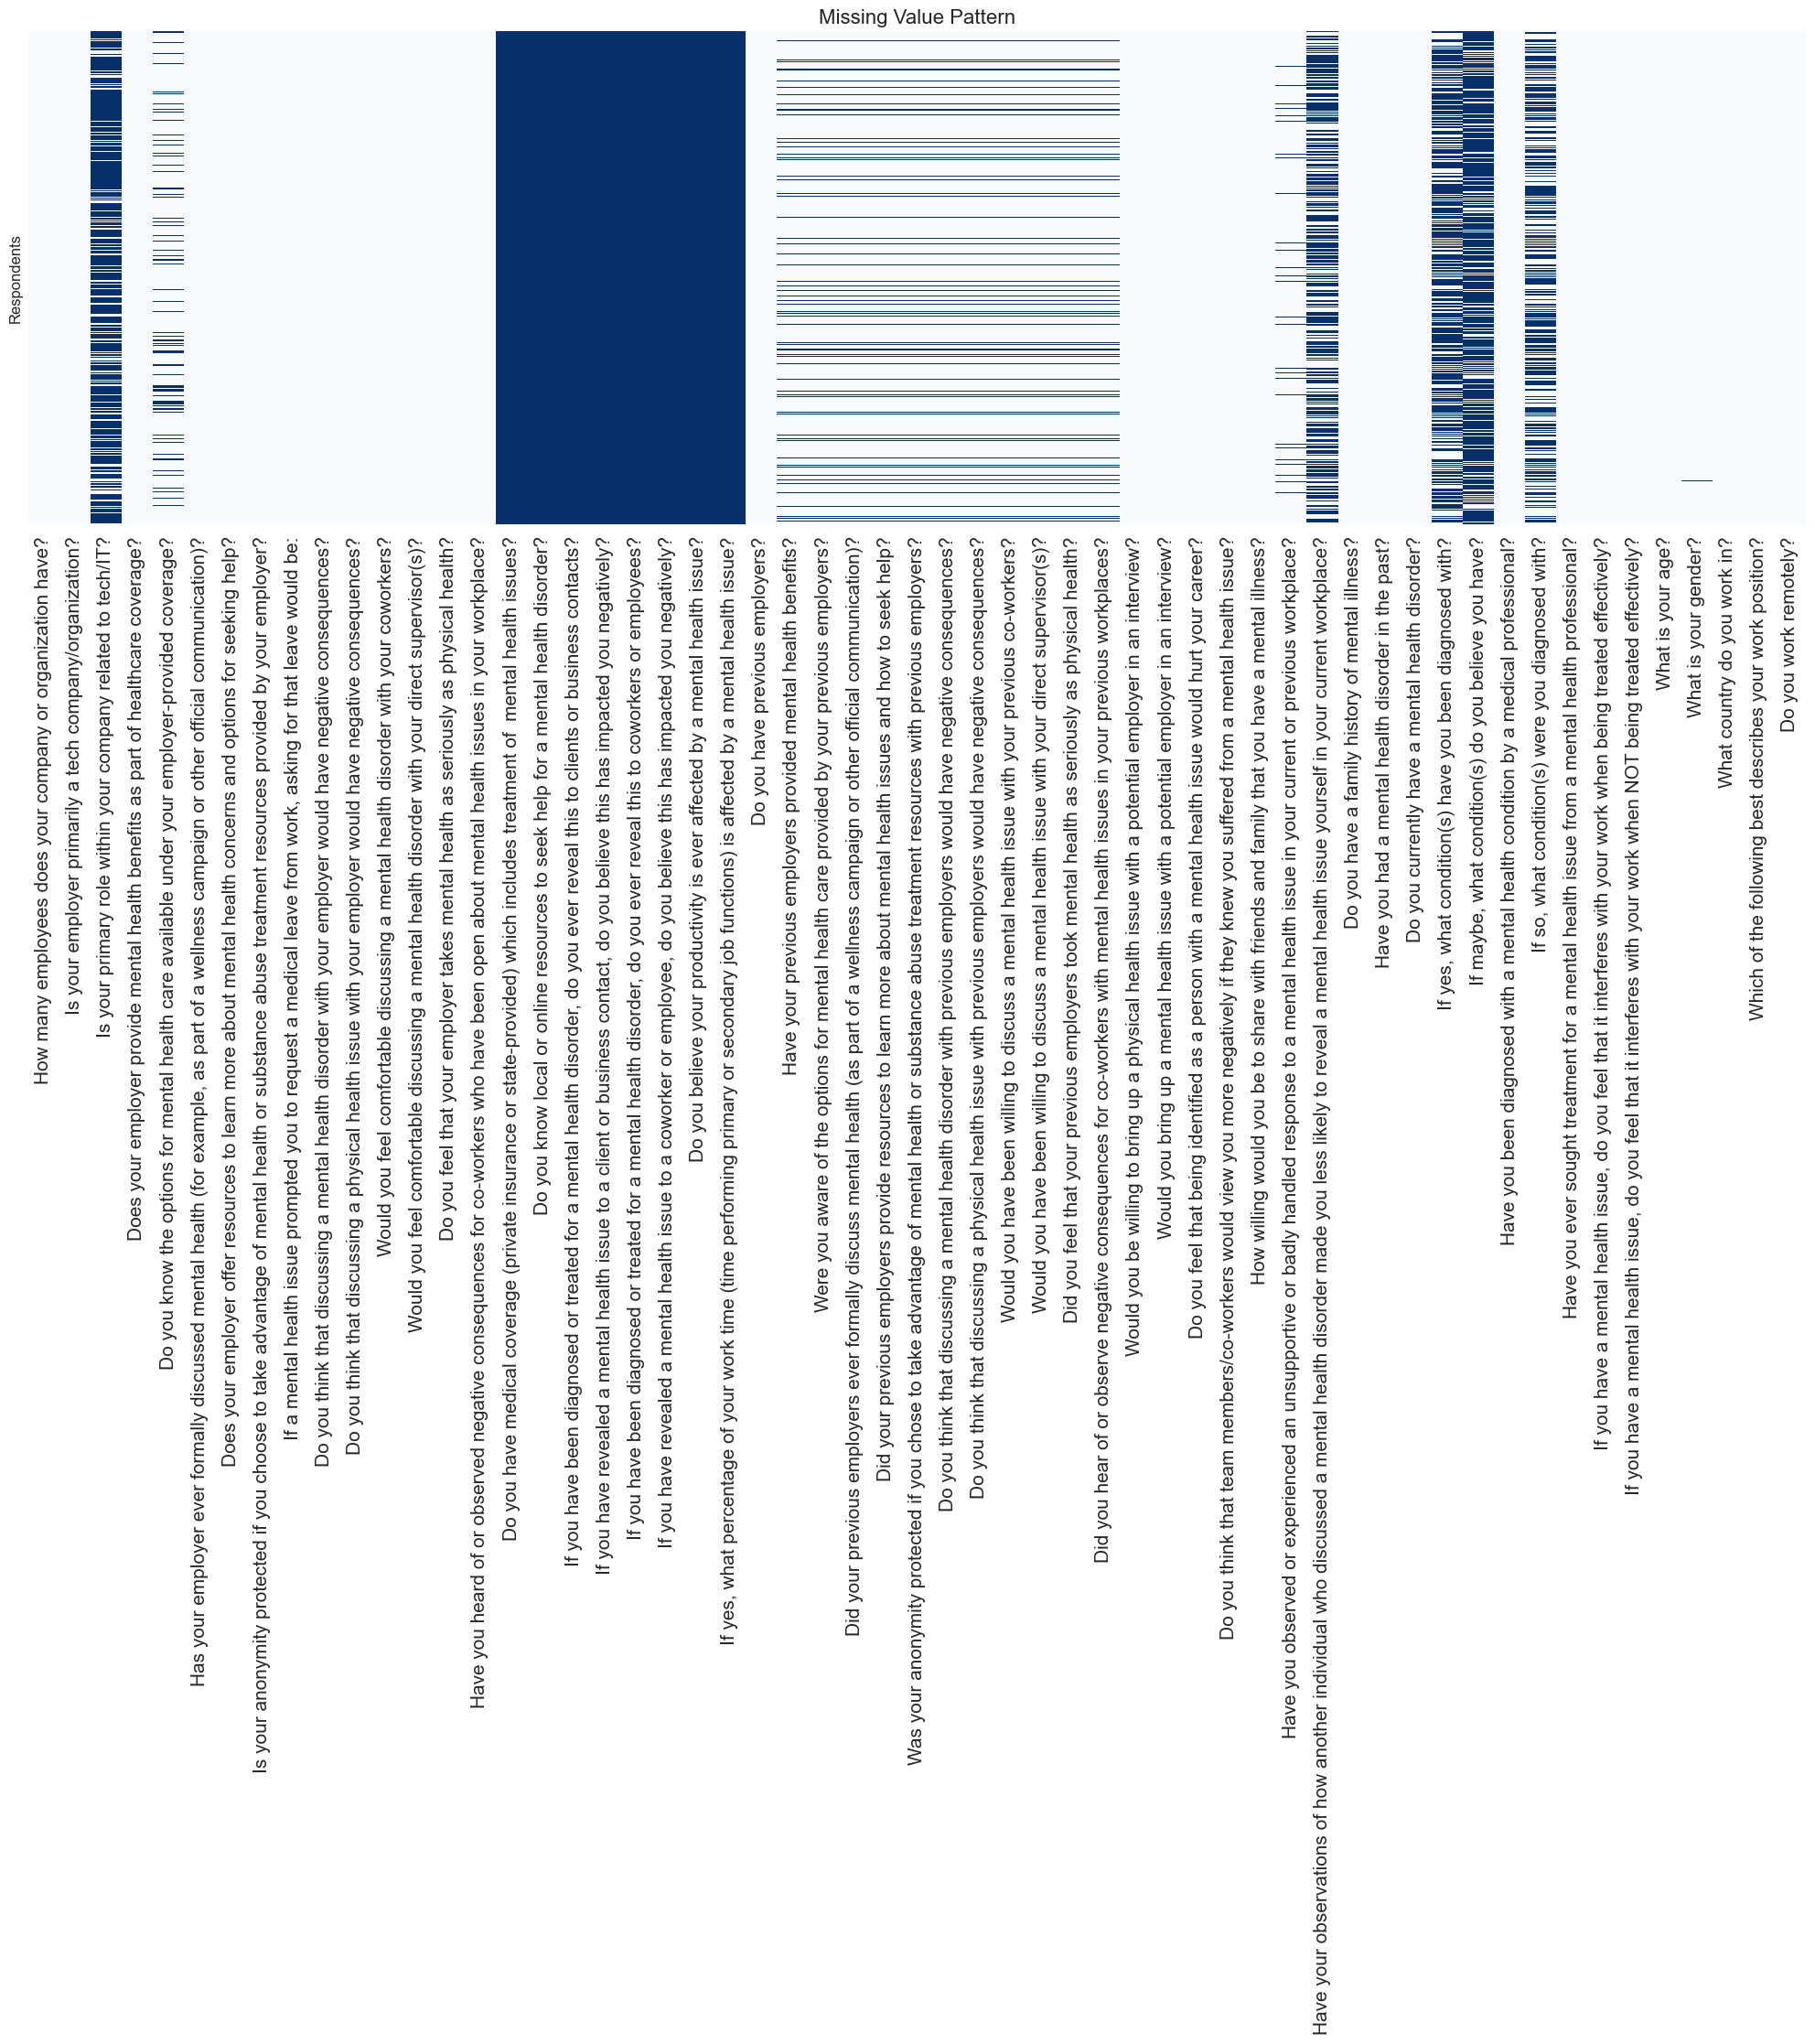

In [26]:
df_scoped = df_raw[df_raw['    "Are you self-employed?"'] == 0].copy()

tech_filter = (
    (df_scoped['Is your employer primarily a tech company/organization?'] == 1) | 
    (df_scoped['Is your primary role within your company related to tech/IT?'] == 1)
)
df_scoped = df_scoped[tech_filter]

cols_to_drop = [
    '    "Are you self-employed?"',
    'What country do you live in?',
    'What US state or territory do you live in?',
    'What US state or territory do you work in?',
    'Why or why not?',
    'Why or why not?.1'
]

df_scoped = df_scoped.drop(columns=cols_to_drop, errors='ignore')

plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_scoped.isna(), cbar=False, cmap='Blues', yticklabels=False)
ax.set_xticks(np.arange(len(df_scoped.columns)) + 0.5)
ax.set_xticklabels(df_scoped.columns, fontsize=15, rotation=90, ha='center')

plt.title('Missing Value Pattern', fontsize=16)
plt.ylabel('Respondents')
plt.tight_layout()
save_fig("missing")
plt.show()

## Figure A2
**Structural Missingness Patterns**

*Referenced in section 2.1.2.*

Saved: struct_missing.png


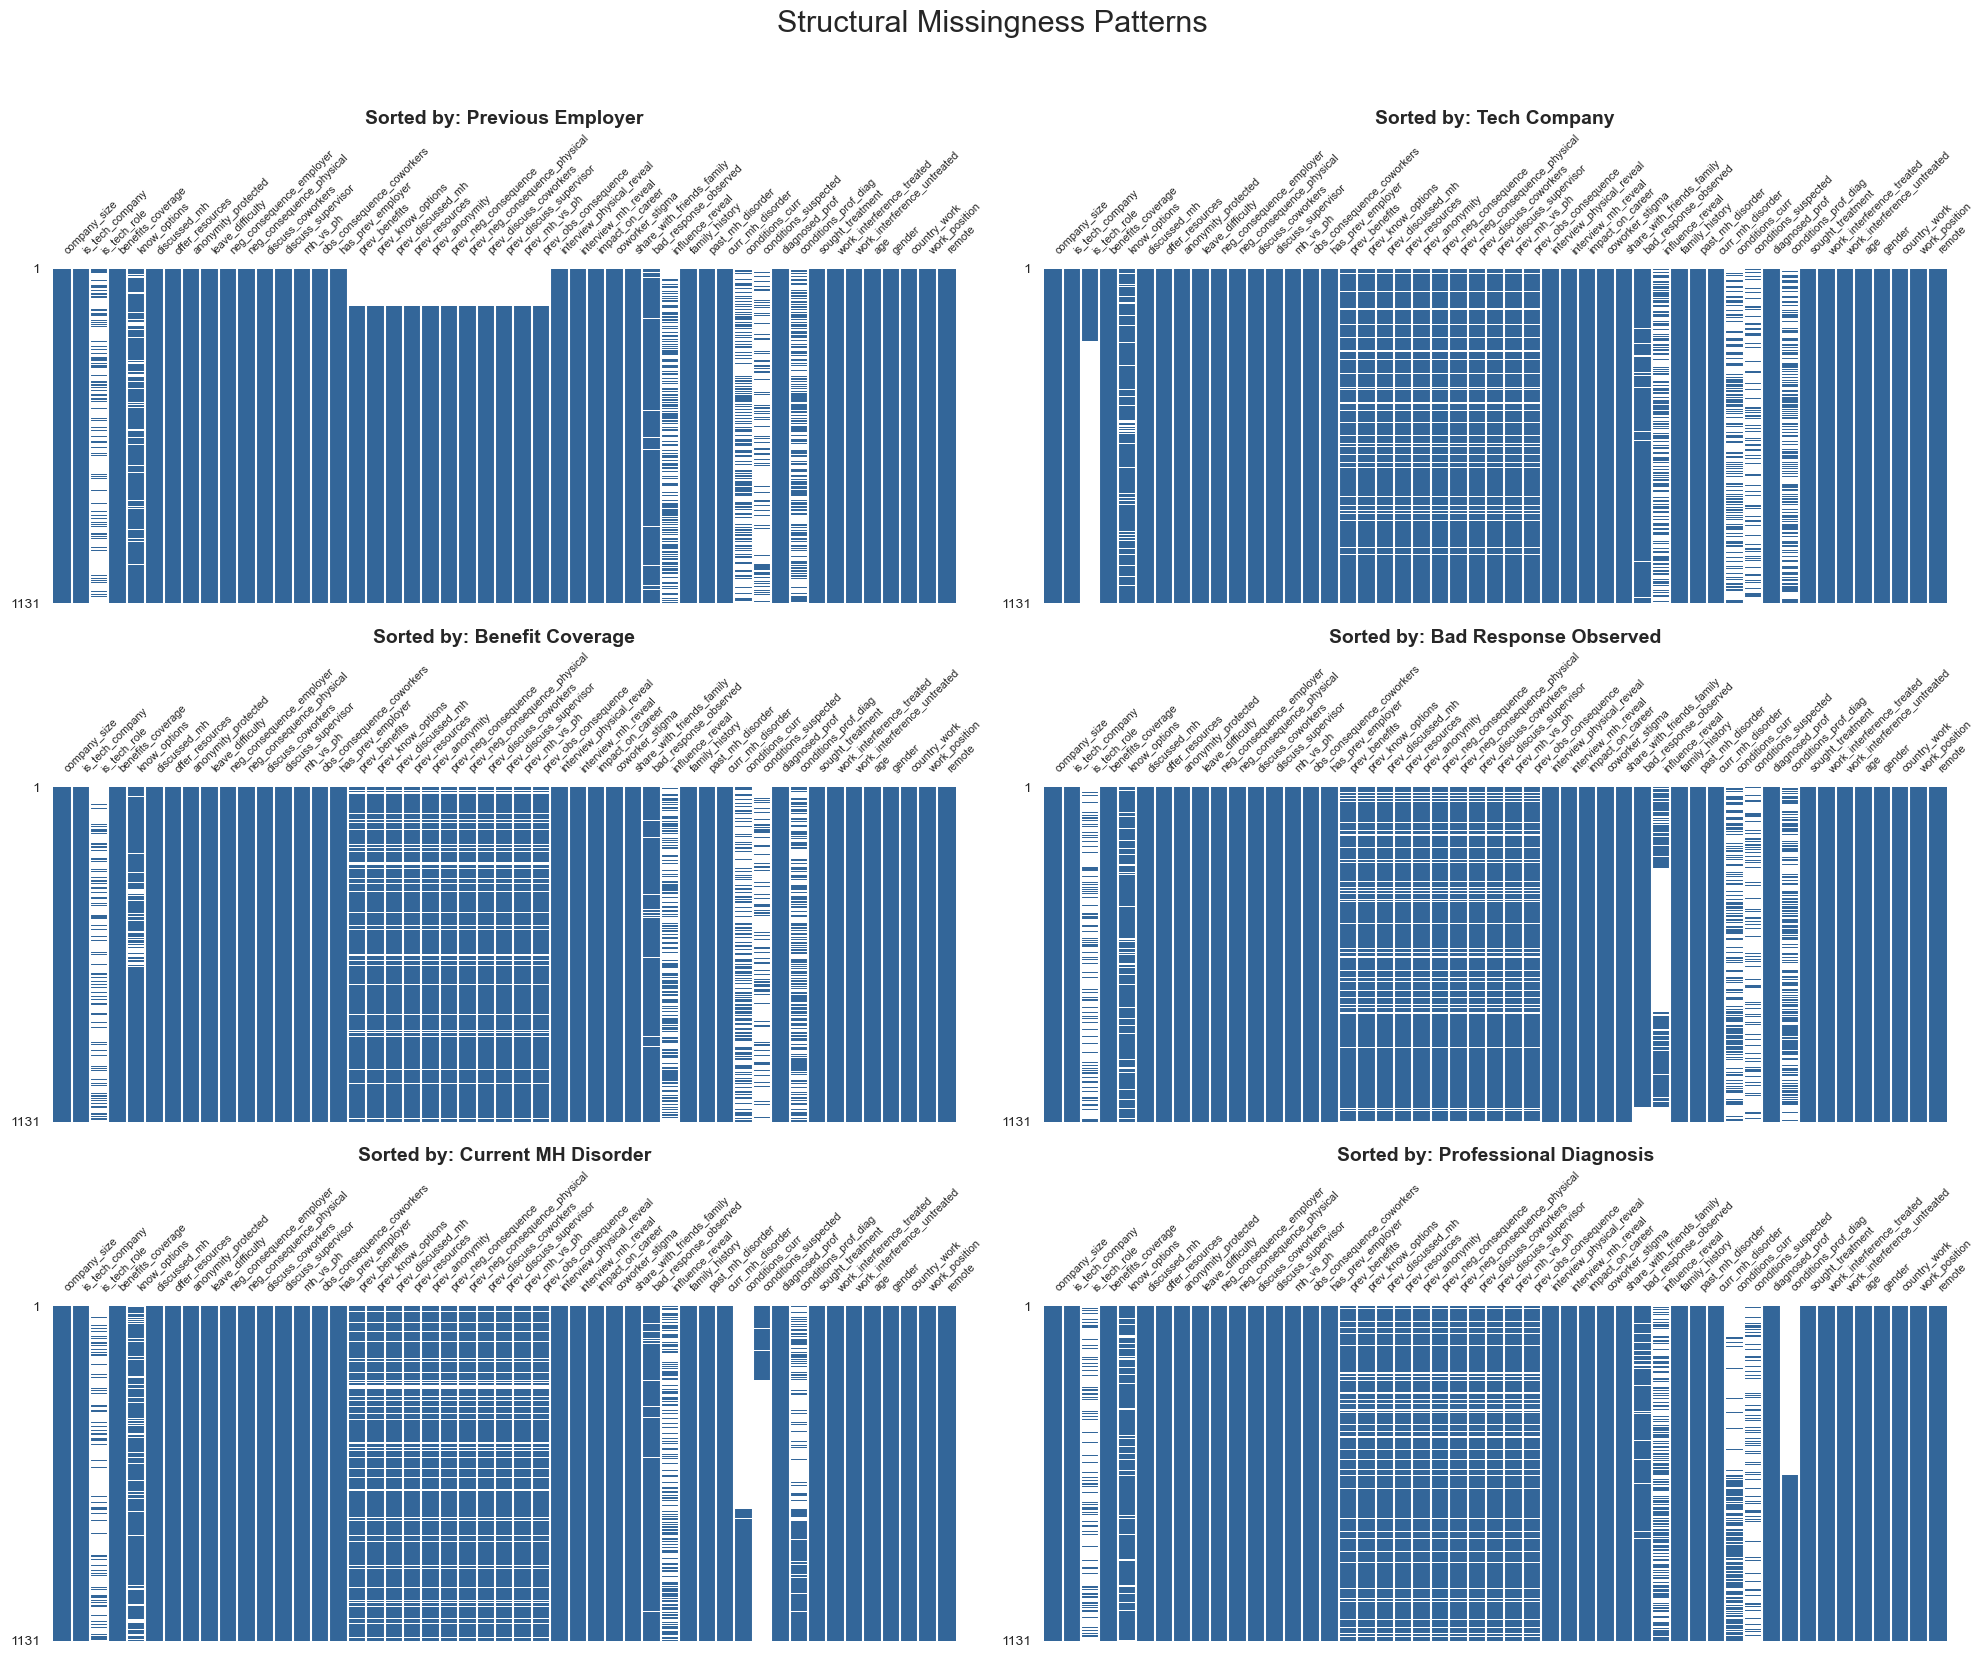

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

sort_cols = ['has_prev_employer', 'is_tech_company', 'benefits_coverage', 'bad_response_observed', 'curr_mh_disorder', 'diagnosed_prof']
titles = ['Previous Employer', 'Tech Company', 'Benefit Coverage', 'Bad Response Observed', 'Current MH Disorder', 'Professional Diagnosis']

for i, col in enumerate(sort_cols):
    row = i // 2
    c = i % 2
    curr = axes[row, c]

    msno.matrix(df_struct.sort_values(col), ax=curr, sparkline=False, fontsize=8, color=(0.2, 0.4, 0.6))

    curr.set_title(f'Sorted by: {titles[sort_cols.index(col)]}', fontsize=14, fontweight='bold')

plt.suptitle('Structural Missingness Patterns', fontsize=22, y=0.92)
plt.tight_layout()
save_fig("struct_missing")
plt.show()

## Figure A3
**Feature Importance (Mutual Information)**

*Referenced in section 2.3.*

Saved: mutual_info.png


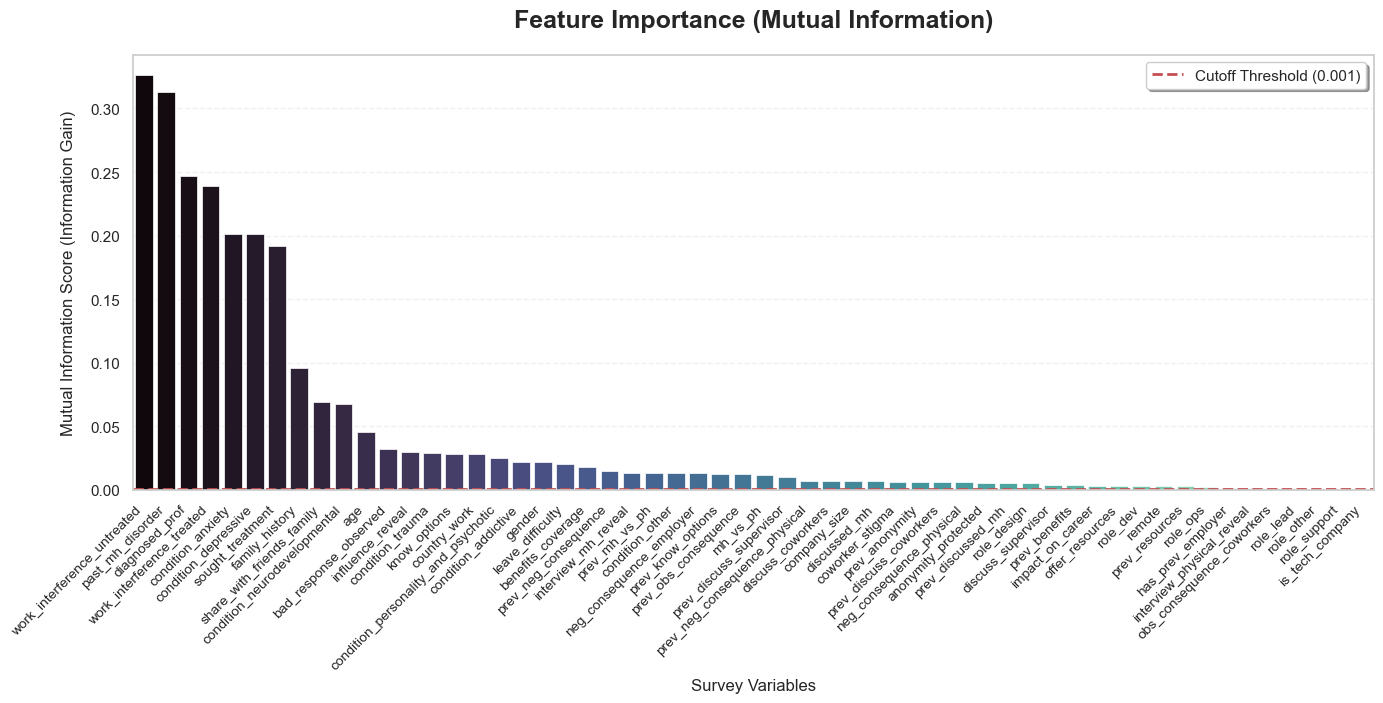

In [28]:
target = 'curr_mh_disorder'
drop_cols = [target] + [c for c in df_clean.columns if c.lower() == 'cluster']
X = df_clean.drop(columns=drop_cols)
y = df_clean[target]

X_encoded = X.apply(lambda x: x.astype('category').cat.codes)

mi_scores = mutual_info_classif(X_encoded, y, discrete_features=True, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(14, 8)) 
n = 57
data_to_plot = mi_series.head(n)
sns.barplot(x=data_to_plot.index, y=data_to_plot.values, palette="mako",edgecolor='white',linewidth=0.5)

threshold = 0.001
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Cutoff Threshold ({threshold})')

plt.title('Feature Importance (Mutual Information)', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Mutual Information Score (Information Gain)', fontsize=12, labelpad=10)
plt.xlabel('Survey Variables', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.legend(frameon=True, shadow=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
save_fig("mutual_info")
plt.show()

## Figure A4
**FAMD Feature Contribution Comparison by Previous Employer**

*Referenced in section 2.4.1.*

Saved: famd_column.png


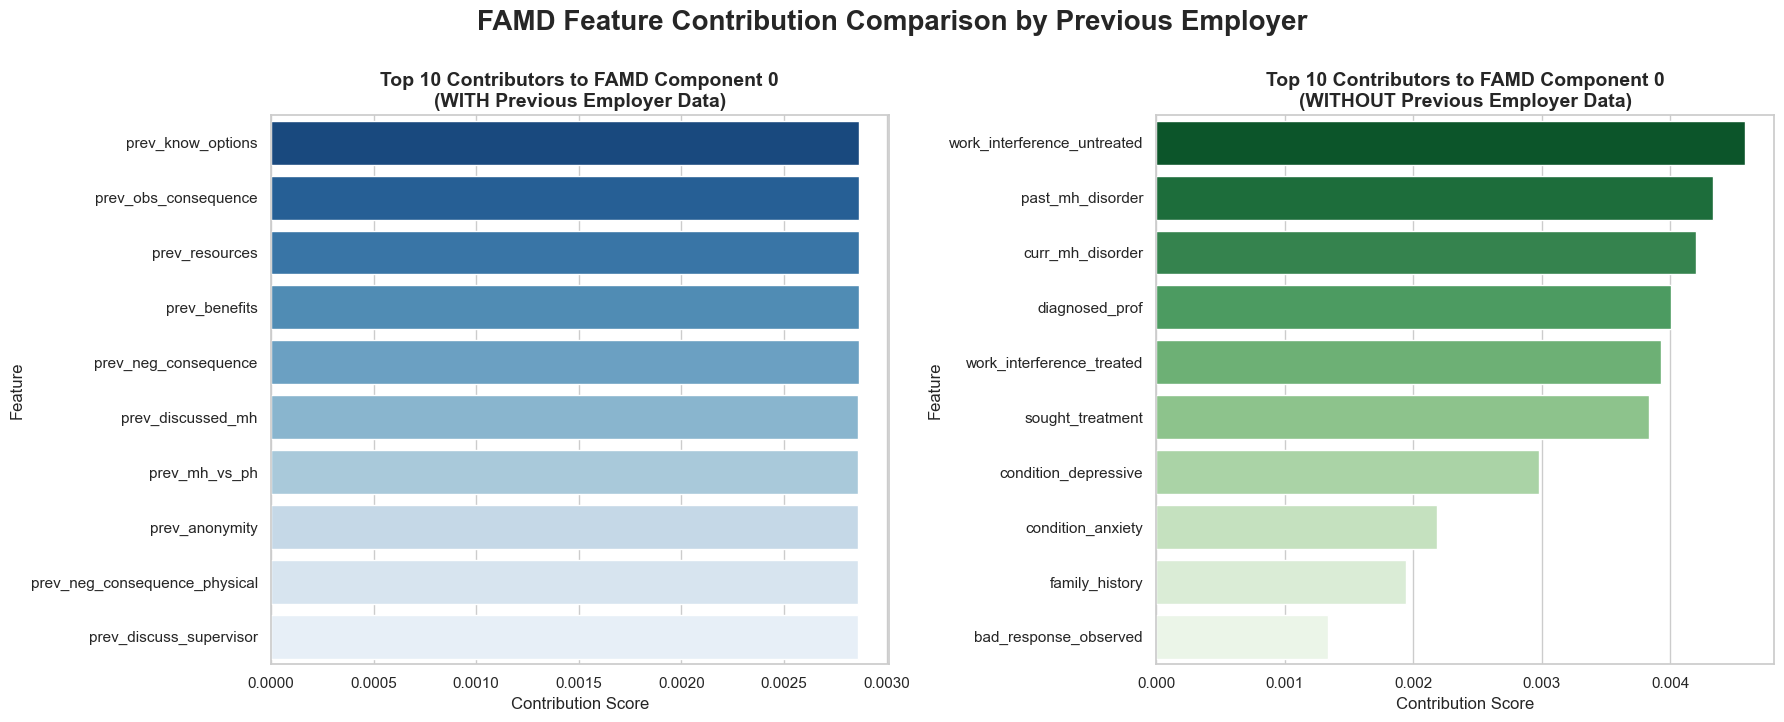

In [29]:
# FAMD Column Contribution Comparison
df_before = pd.read_csv('../data/processed/df_cat.csv', keep_default_na=False, na_values='')
cat_cols = df_before.select_dtypes(exclude=['number']).columns
df_before[cat_cols] = df_before[cat_cols].astype('category')

famd_before = FAMD(n_components=2, n_iter=3, random_state=42)
famd_before.fit(df_before)
contrib_before = famd_before.column_contributions_[0].sort_values(ascending=False).head(10)

prev_cols = [col for col in df_before.columns if 'prev' in col] + ['has_prev_employer']
df_after = df_before.drop(columns=prev_cols, errors='ignore')

famd_after = FAMD(n_components=2, n_iter=5, random_state=42)
famd_after.fit(df_after)
contrib_after = famd_after.column_contributions_[0].sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(x=contrib_before.values, y=contrib_before.index, ax=axes[0], palette="Blues_r")
axes[0].set_title('Top 10 Contributors to FAMD Component 0\n(WITH Previous Employer Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Contribution Score')
axes[0].set_ylabel('Feature')

sns.barplot(x=contrib_after.values, y=contrib_after.index, ax=axes[1], palette="Greens_r")
axes[1].set_title('Top 10 Contributors to FAMD Component 0\n(WITHOUT Previous Employer Data)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Contribution Score')
axes[1].set_ylabel('Feature')

plt.suptitle('FAMD Feature Contribution Comparison by Previous Employer', fontsize=20, y=0.9, fontweight='bold')
plt.tight_layout()
save_fig("famd_column")
plt.show()

## Figure A5
**Impact of Previous Employer Data on FAMD Global Structure**

*Referenced in section 2.4.1.*

Saved: famd_plot.png


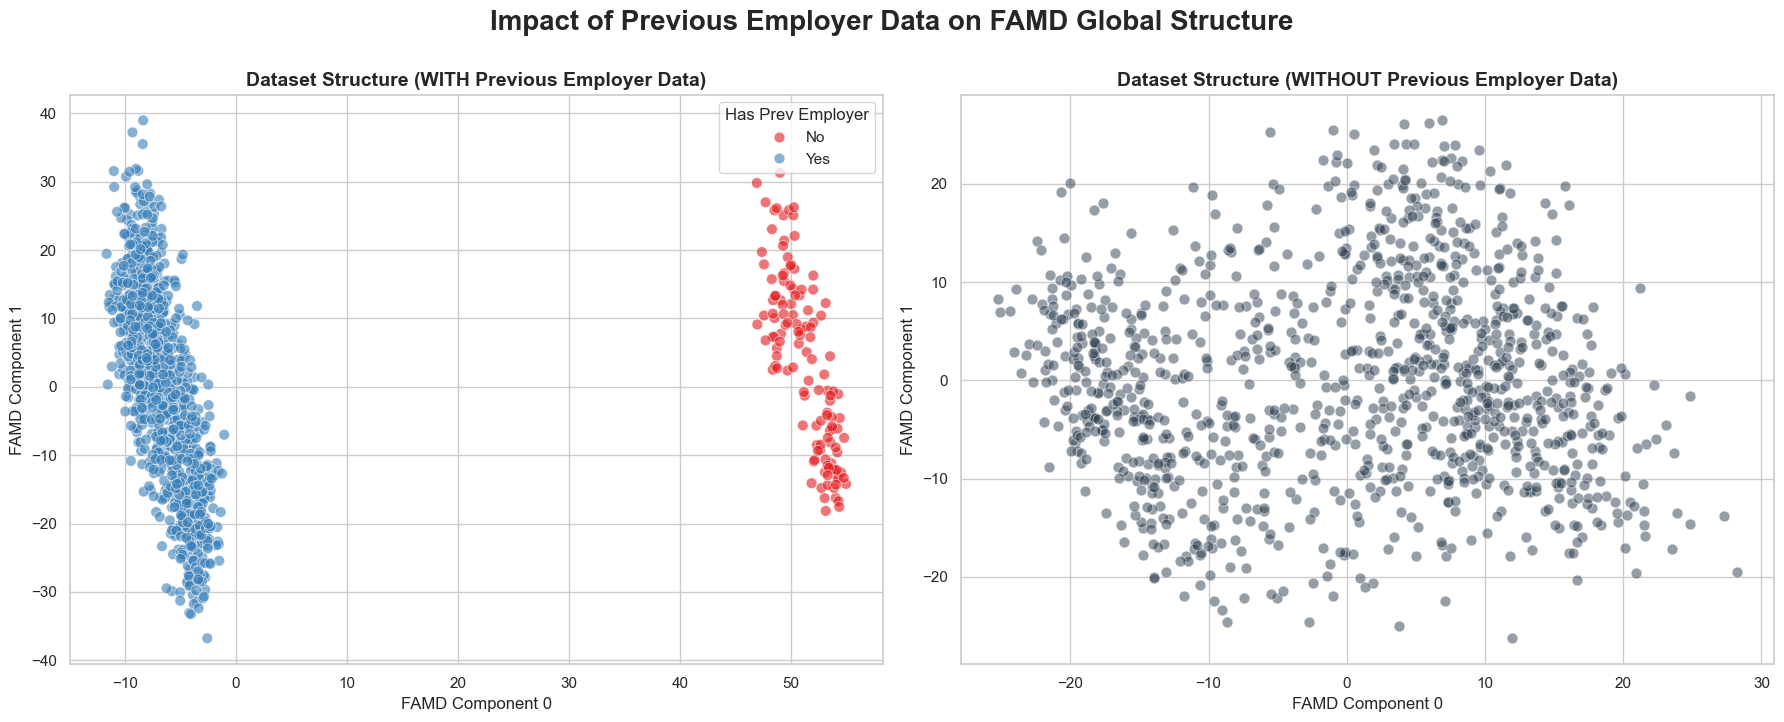

In [30]:
# FAMD Plotting Comparison
coords_before = famd_before.row_coordinates(df_before)
coords_after = famd_after.row_coordinates(df_after)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(
    data=coords_before, x=0, y=1, 
    hue=df_before['has_prev_employer'], 
    palette='Set1', alpha=0.6, s=60, ax=axes[0]
)
axes[0].set_title('Dataset Structure (WITH Previous Employer Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('FAMD Component 0')
axes[0].set_ylabel('FAMD Component 1')
axes[0].legend(title='Has Prev Employer', loc='best')

sns.scatterplot(
    data=coords_after, x=0, y=1, 
    color='#2c3e50', alpha=0.5, s=60, ax=axes[1]
)
axes[1].set_title('Dataset Structure (WITHOUT Previous Employer Data)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('FAMD Component 0')
axes[1].set_ylabel('FAMD Component 1')

plt.suptitle('Impact of Previous Employer Data on FAMD Global Structure', fontsize=20, y=0.9, fontweight='bold')
plt.tight_layout()
save_fig("famd_plot")
plt.show()

## Figure A6
**Impact of Previous Employer Data on t-SNE Manifold Structure**

*Referenced in section 2.4.2.*

Saved: tsne_comparison.png


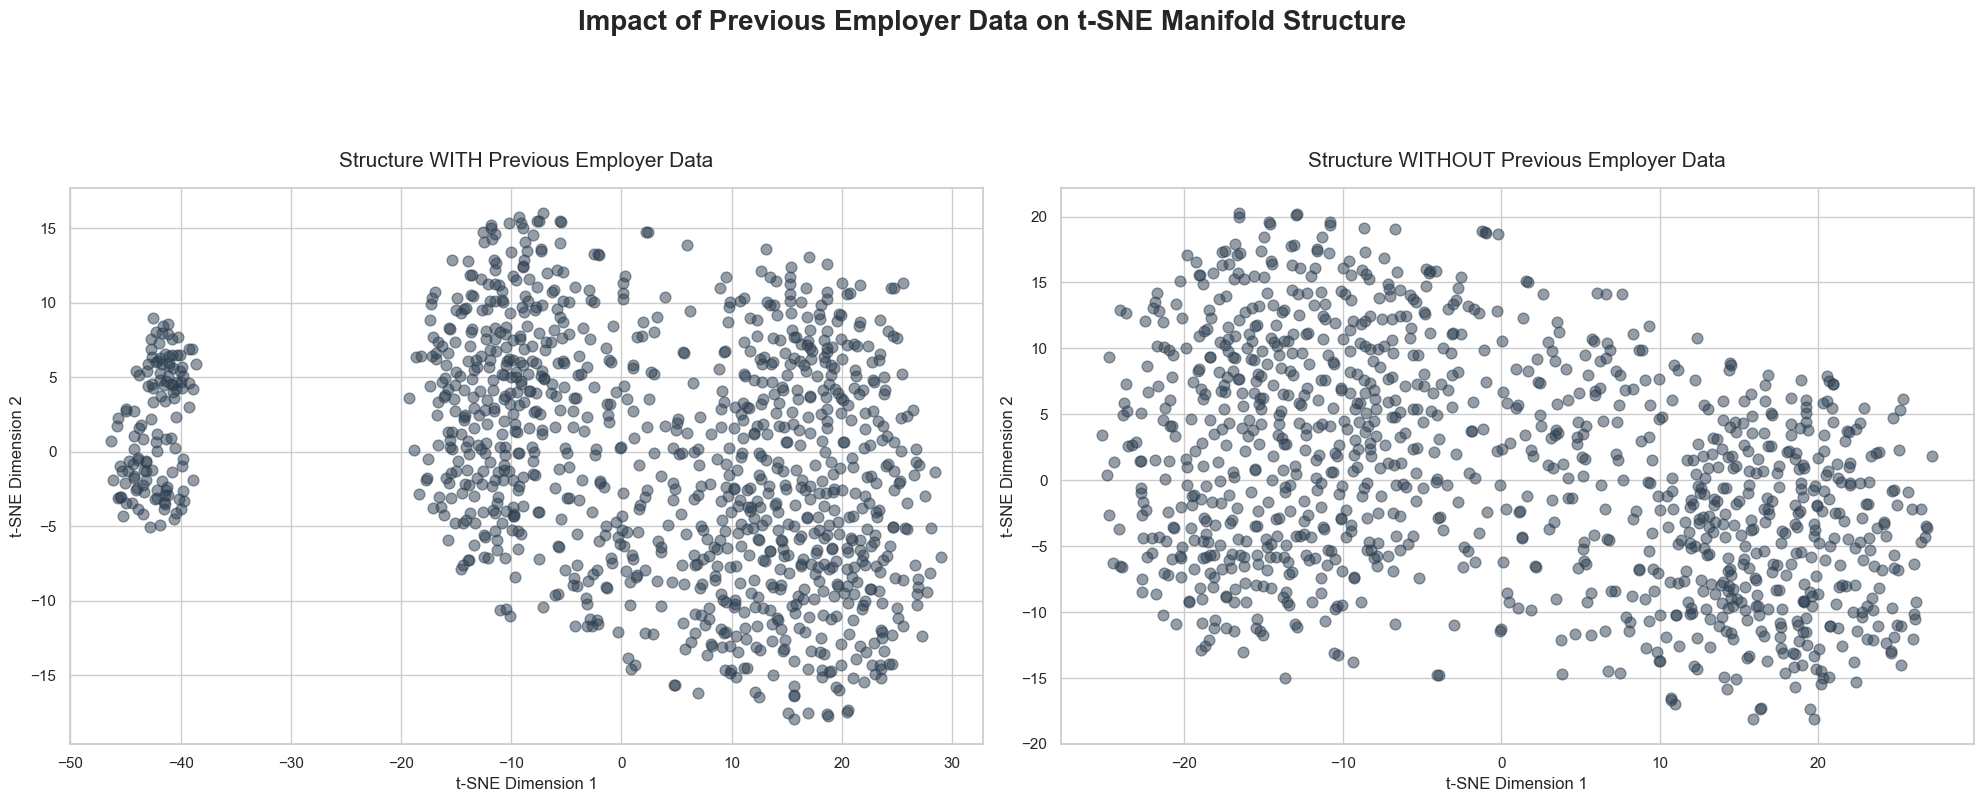

In [31]:
def get_tsne_coords(df):
    df_temp = df.copy()
    for col in df_temp.select_dtypes(include=['category']).columns:
        df_temp[col] = df_temp[col].astype('object')
    
    dist_matrix = gower.gower_matrix(df_temp)
    tsne = TSNE(n_components=2, metric='precomputed', random_state=42, perplexity=40, init='random')
    return tsne.fit_transform(dist_matrix)

coords_before = get_tsne_coords(df_before)
coords_after = get_tsne_coords(df_after)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
dot_color = '#2c3e50'
dot_size = 60
dot_alpha = 0.5

axes[0].scatter(coords_before[:, 0], coords_before[:, 1], c=dot_color, s=dot_size, alpha=dot_alpha)
axes[0].set_title('Structure WITH Previous Employer Data', fontsize=15, pad=15)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

axes[1].scatter(coords_after[:, 0], coords_after[:, 1], c=dot_color, s=dot_size, alpha=dot_alpha)
axes[1].set_title('Structure WITHOUT Previous Employer Data', fontsize=15, pad=15)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

plt.suptitle('Impact of Previous Employer Data on t-SNE Manifold Structure', fontsize=20, y=1.0, fontweight='bold')
plt.tight_layout()

save_fig("tsne_comparison")
plt.show()

## Figure A7
**Elbow Method Plot**

*Referenced in section 3.2.*

Saved: elbow_method.png


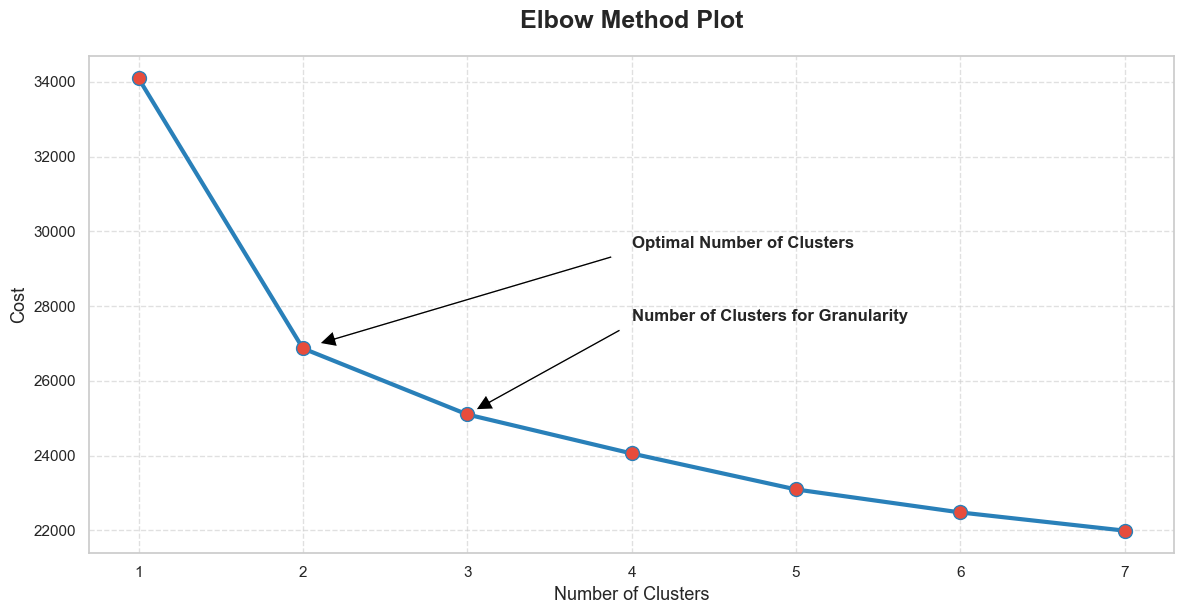

In [32]:
# Elbow Method
X_proto = df_after.values
cat_idx = [df_after.columns.get_loc(c) for c in df_after.select_dtypes(include=['category', 'object']).columns]

costs = []
k_range = range(1, 8)

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, verbose=0, random_state=42, gamma=1.5)
    kproto.fit(X_proto, categorical=cat_idx)
    costs.append(kproto.cost_)


plt.figure(figsize=(12, 7))
plt.plot(k_range, costs, marker='o', markersize=10, linestyle='-', linewidth=3, color='#2980b9', markerfacecolor='#e74c3c')

plt.annotate('Optimal Number of Clusters', xy=(2, costs[1]), xytext=(4, costs[1]*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=12, fontweight='bold')
plt.annotate('Number of Clusters for Granularity', xy=(3, costs[2]), xytext=(4, costs[2]*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=12, fontweight='bold')

plt.title('Elbow Method Plot', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Cost', fontsize=13)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
save_fig("elbow_method")
plt.show()

## Figure A8
**Hierarchical Clustering Dendrogram**

*Referenced in section 3.2.*

Saved: hierarchical.png


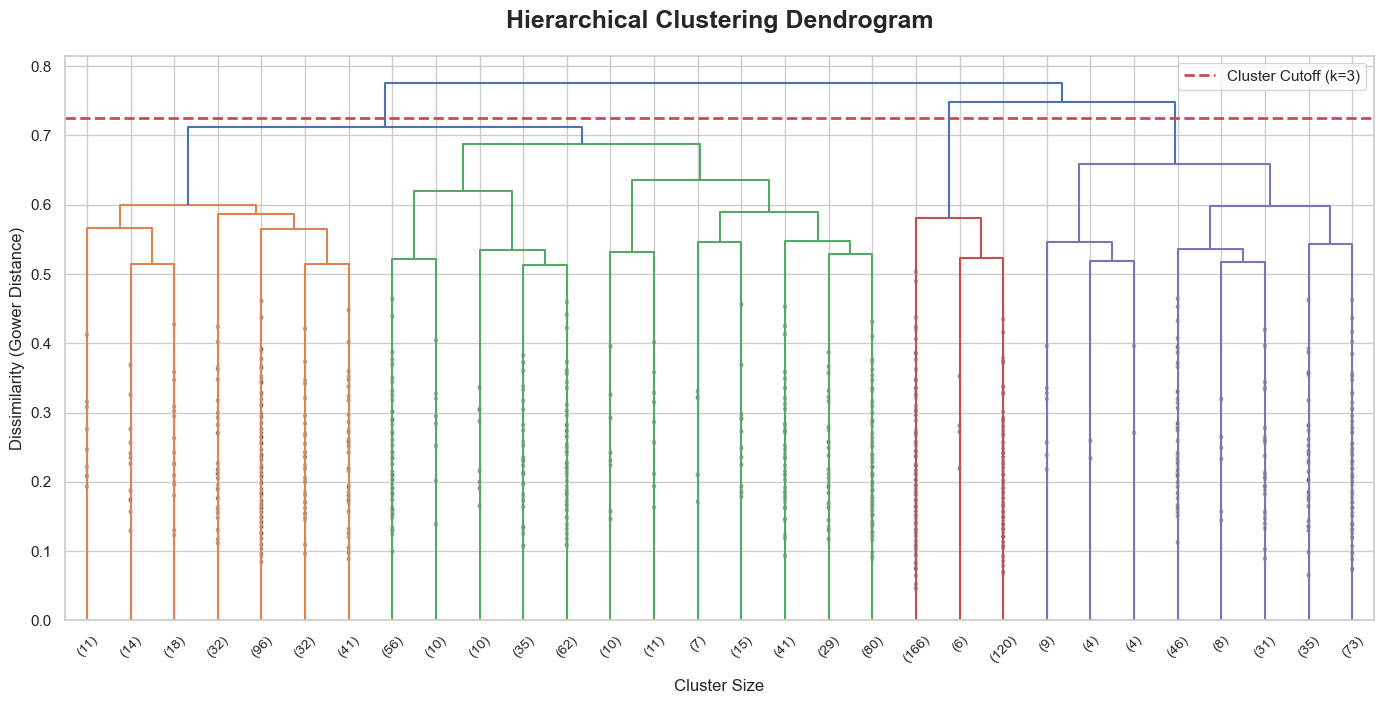

In [33]:
#Hierarchical Clustering Dendrogram
df_temp = df_after.copy()
for col in df_temp.select_dtypes(include=['category']).columns:
    df_temp[col] = df_temp[col].astype('object')
    
dist_matrix = gower.gower_matrix(df_temp)
gower_cond = squareform(dist_matrix, checks=False)
Z = linkage(gower_cond, method='complete')

plt.figure(figsize=(14, 8))

ddata = dendrogram(
    Z, 
    truncate_mode='lastp', 
    p=30, 
    leaf_rotation=45, 
    leaf_font_size=10, 
    show_contracted=True,
    color_threshold=0.70
)

plt.axhline(y=0.725, color='r', linestyle='--', linewidth=2, label='Cluster Cutoff (k=3)')

plt.title('Hierarchical Clustering Dendrogram', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Cluster Size', fontsize=12, labelpad=10)
plt.ylabel('Dissimilarity (Gower Distance)', fontsize=12)
plt.legend(loc='upper right')

plt.tight_layout()
save_fig("hierarchical")
plt.show()

## Figure A9
**Silhouette Score Analysis**

*Referenced in section 3.2.*

Saved: silhouette.png


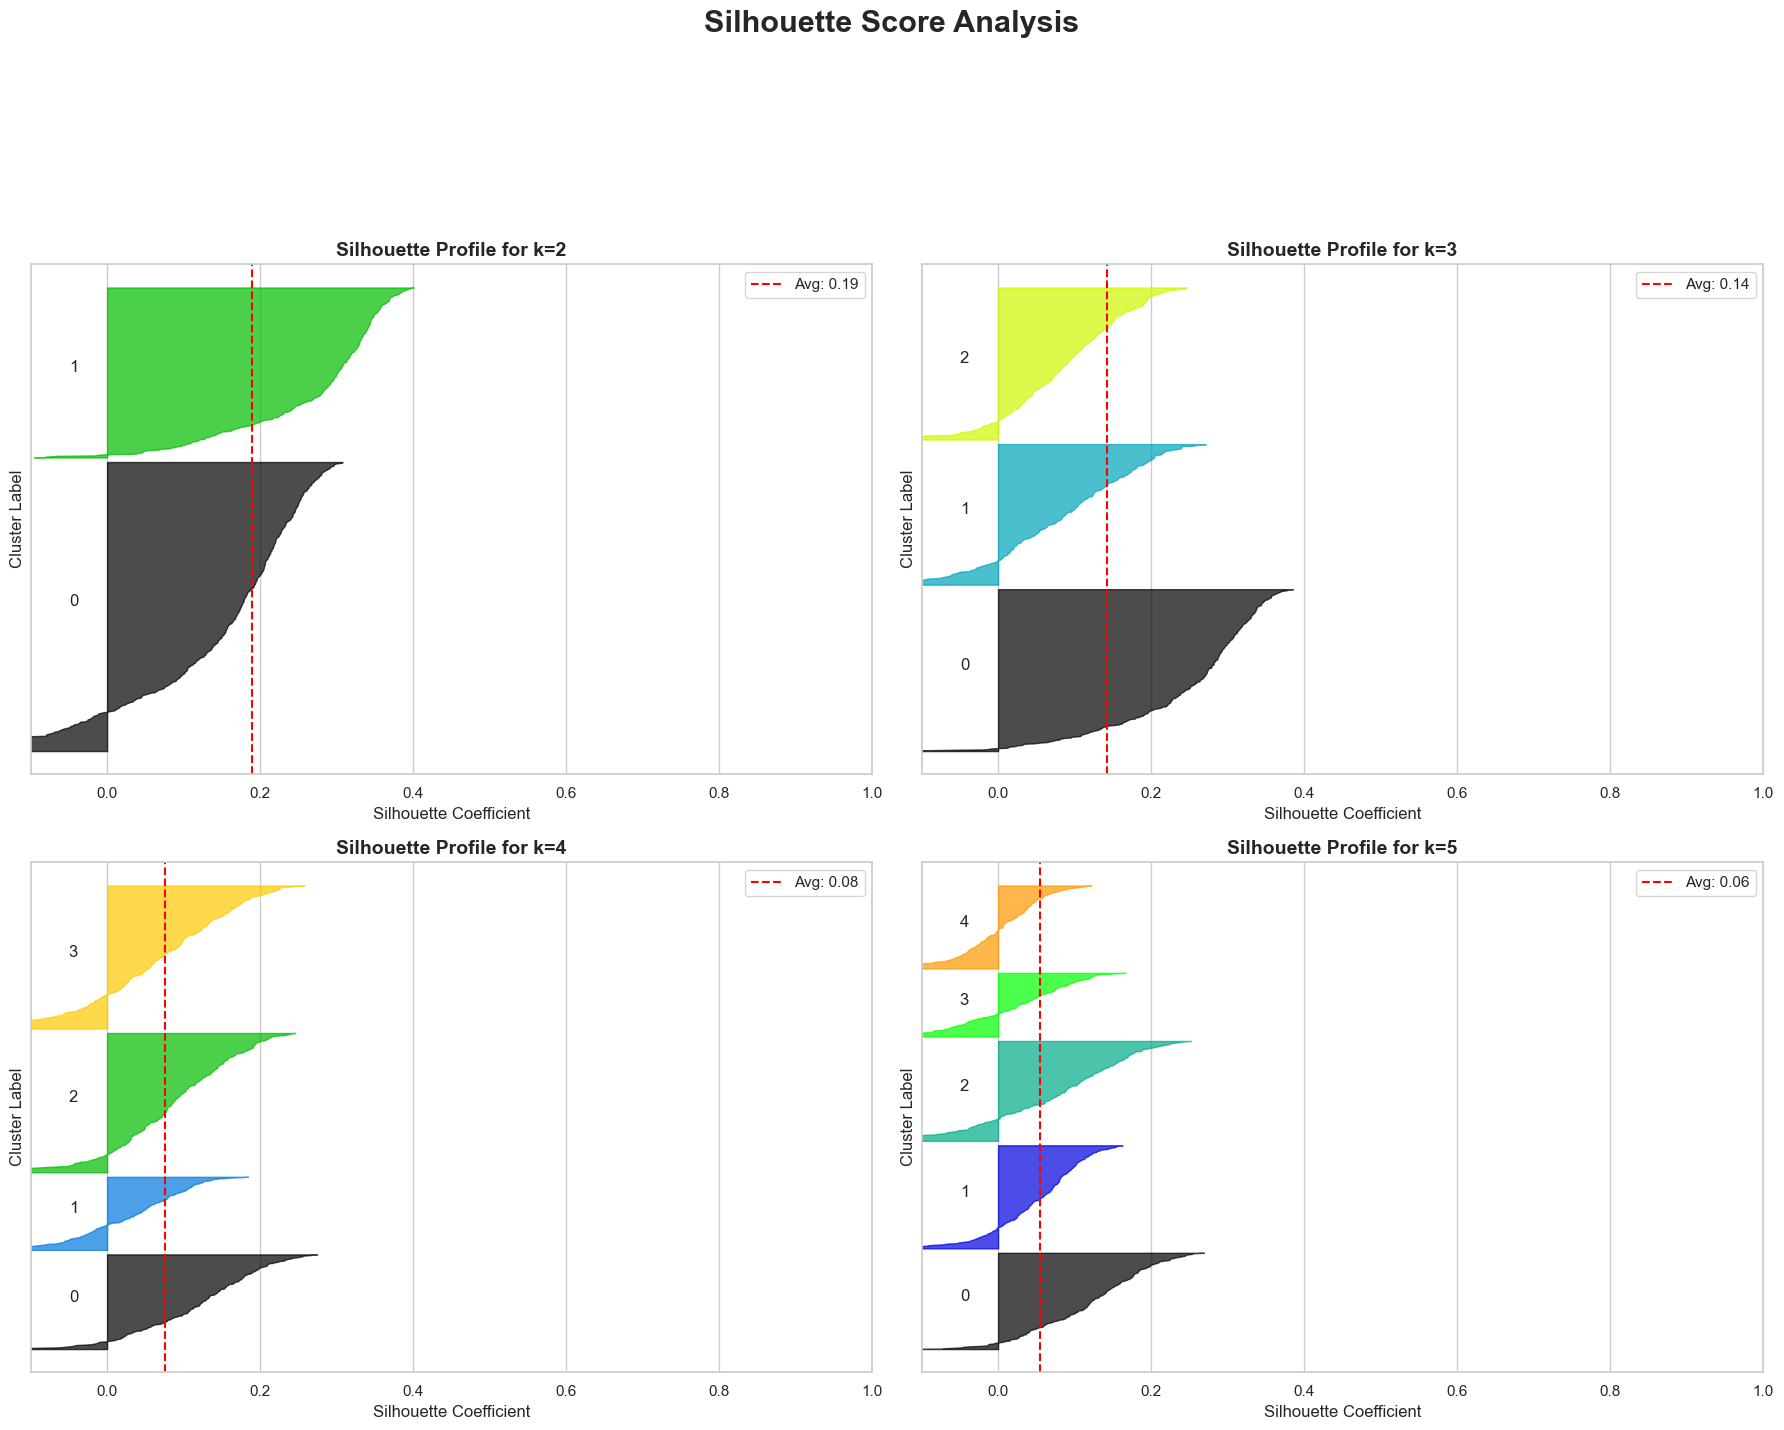

In [34]:
candidates = [2, 3, 4, 5]
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for i, k in enumerate(candidates):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    kp = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42, gamma=1.5)
    labels = kp.fit_predict(df_after.values, categorical=cat_idx)

    avg_score = silhouette_score(dist_matrix, labels, metric='precomputed')
    sample_values = silhouette_samples(dist_matrix, labels, metric='precomputed')
    
    y_lower = 10
    
    for j in range(k):
        cluster_values = sample_values[labels == j]
        cluster_values.sort()
        
        size_cluster_j = cluster_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    ax.axvline(x=avg_score, color="red", linestyle="--", label=f'Avg: {avg_score:.2f}')
    ax.set_title(f'Silhouette Profile for k={k}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster Label')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.legend(loc='upper right')

plt.suptitle('Silhouette Score Analysis', 
             fontsize=22, y=1.02, fontweight='bold')
plt.tight_layout()
save_fig("silhouette")
plt.show()

## Figure A10
**Stability Analysis (Adjusted Rand Index)**

*Referenced in section 3.2.*

Calculating Cluster Stability (ARI)...
Saved: ari.png


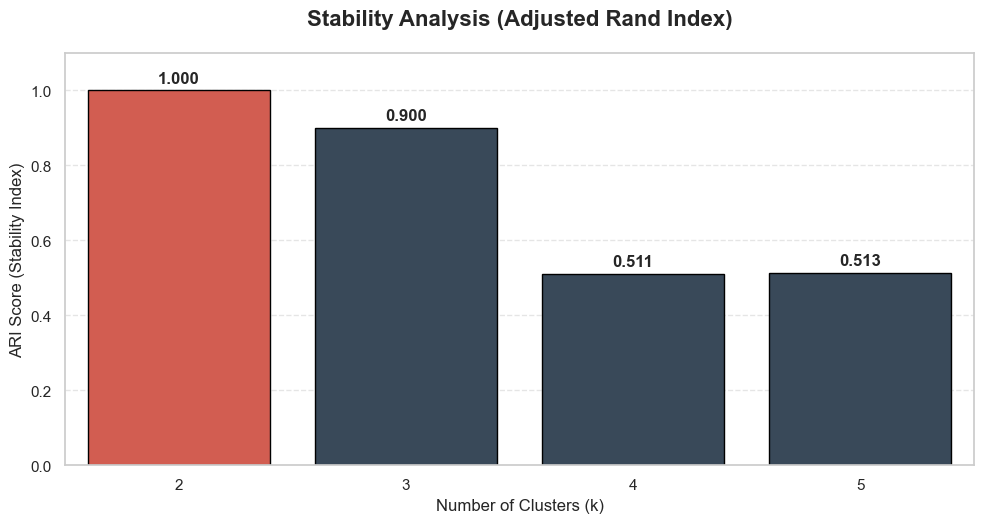

In [35]:
stability_scores = []
candidates = [2, 3, 4, 5]

print("Calculating Cluster Stability (ARI)...")
for k in candidates:
    kp1 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=42, gamma=1.5)
    labels1 = kp1.fit_predict(df_after, categorical=cat_idx)
    
    kp2 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=101, gamma=1.5)
    labels2 = kp2.fit_predict(df_after, categorical=cat_idx)
    score = adjusted_rand_score(labels1, labels2)
    stability_scores.append(score)

plt.figure(figsize=(10, 6))
colors = ['#34495e' if s < max(stability_scores) else '#e74c3c' for s in stability_scores]

sns.barplot(x=candidates, y=stability_scores, palette=colors, edgecolor='black')
plt.title('Stability Analysis (Adjusted Rand Index)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('ARI Score (Stability Index)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, score in enumerate(stability_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
save_fig("ari")
plt.show()

## Figure 3
**Final Clustering Results**

*Shown in section 3.3.*

Saved: clusters.png


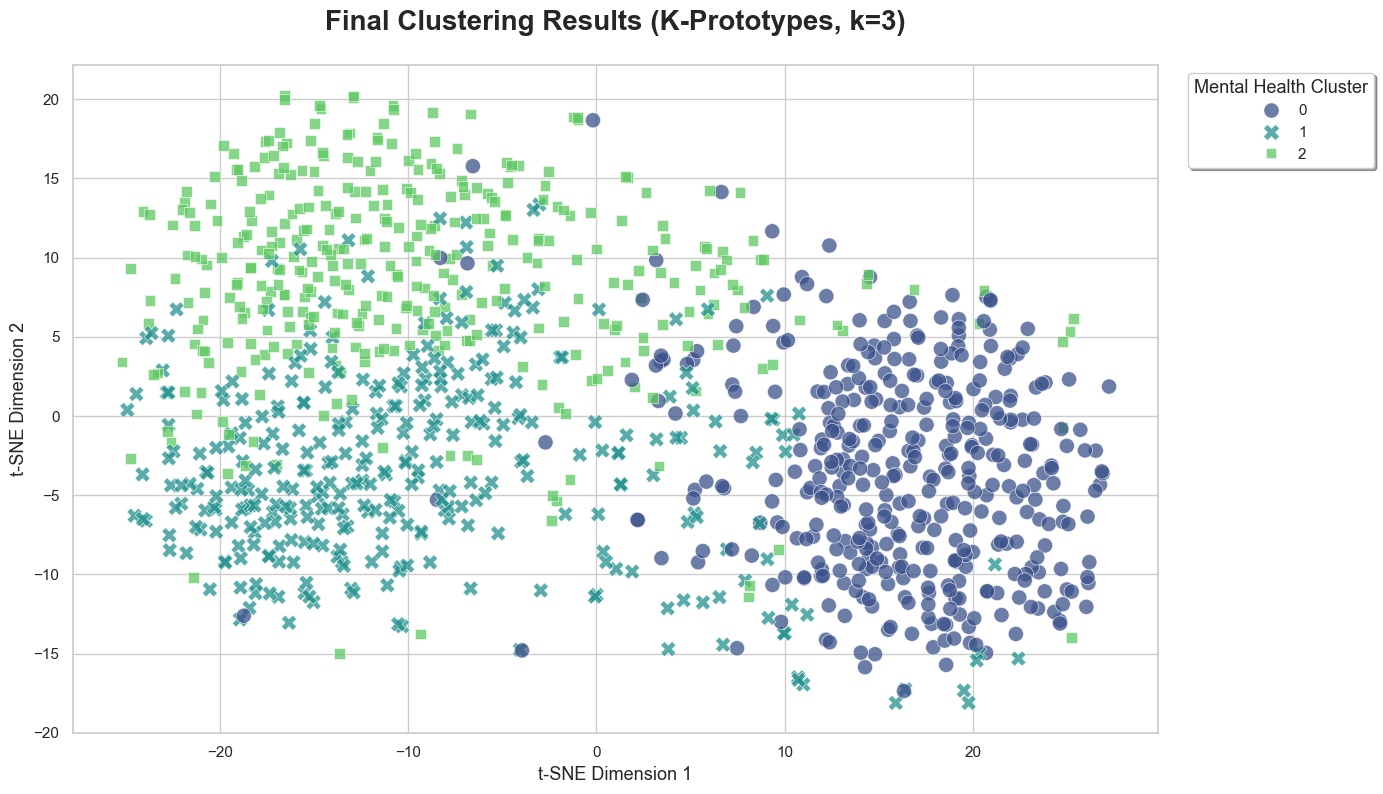

In [36]:
# Final Clustering Visualization

tsne = TSNE(
    n_components=2, 
    metric='precomputed',
    init='random', 
    perplexity=40, 
    random_state=42, 
    n_jobs=-1
)
tsne_results = tsne.fit_transform(dist_matrix)

plt.figure(figsize=(14, 9))

sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1],
    hue=df_final['Cluster'].astype(str),
    style=df_final['Cluster'].astype(str),
    palette='viridis', 
    s=120,
    alpha=0.75, 
    edgecolor='white',
    linewidth=0.5
)


plt.title(f'Final Clustering Results (K-Prototypes, k={3})', 
          fontsize=20, fontweight='bold', pad=25)
plt.xlabel('t-SNE Dimension 1', fontsize=13)
plt.ylabel('t-SNE Dimension 2', fontsize=13)

plt.legend(
    title='Mental Health Cluster', 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left',
    fontsize=11, 
    title_fontsize=13,
    frameon=True,
    shadow=True
)

plt.tight_layout()
save_fig("clusters")
plt.show()

## Figure A11
**Cluster Profiles: Key Differentiators**

*Referenced in section 3.3.*

Saved: radar.png


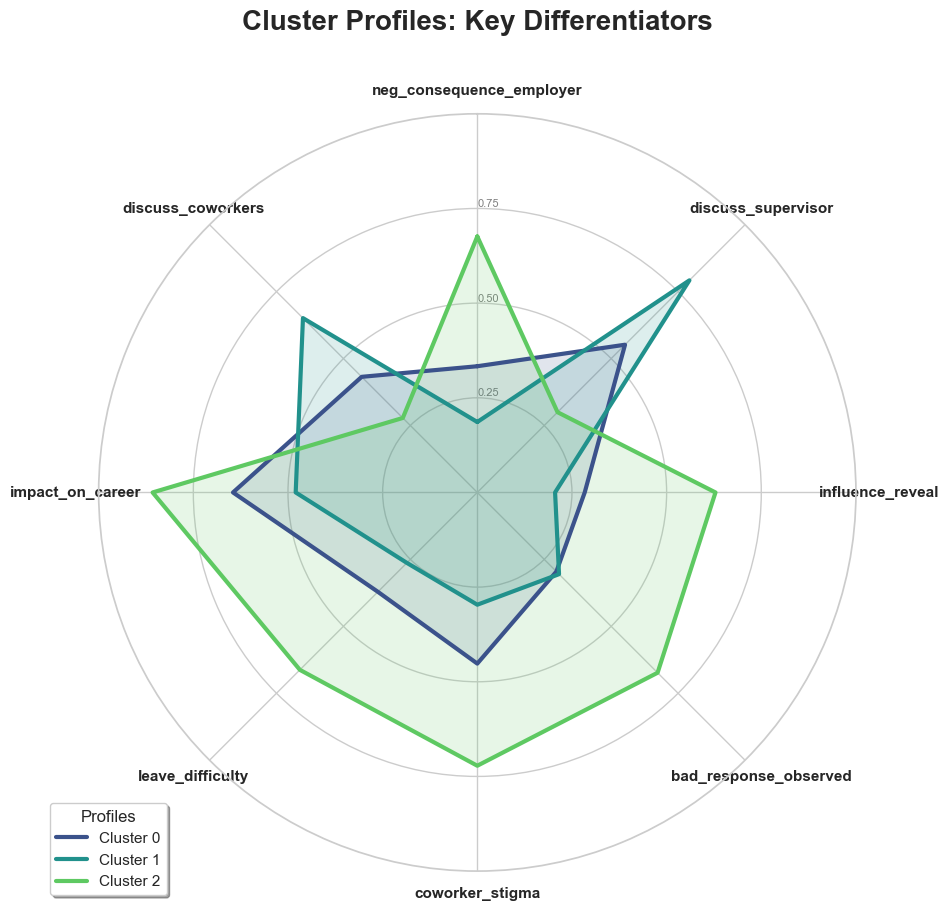

In [37]:
def plot_final_radar(df, cluster_col='Cluster'):
    ordinals = [c for c in df.select_dtypes(include=np.number).columns if c not in [cluster_col, 'age', 'curr_mh_disorder', 'past_mh_disorder', 'work_interference_treated', 'work_interference_untreated', 'Unnamed: 0']]
    norm = MinMaxScaler()
    df_norm = df.copy()
    df_norm[ordinals] = norm.fit_transform(df[ordinals])
    
    means = df_norm.groupby(cluster_col)[ordinals].mean()
    categories = means.var().sort_values(ascending=False).head(8).index.tolist()
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, fontsize=11, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=8)
    plt.ylim(0, 1)

    palette = sns.color_palette("viridis", len(means))
    
    for i, cluster in enumerate(means.index):
        values = means.loc[cluster, categories].values.tolist()
        values += values[:1] 
        
        ax.plot(angles, values, linewidth=3, linestyle='solid', 
                label=f'Cluster {cluster}', color=palette[i])
        ax.fill(angles, values, color=palette[i], alpha=0.15)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), 
               frameon=True, shadow=True, title="Profiles")
    plt.title('Cluster Profiles: Key Differentiators', size=20, fontweight='bold', y=1.1)
    
    plt.tight_layout()
    save_fig("radar")
    plt.show()

plot_final_radar(df_final)

## Figure A12
**Cluster Distribution of Mental Health Status**

*Referenced in section 3.3.*

Saved: cluster_mh.png


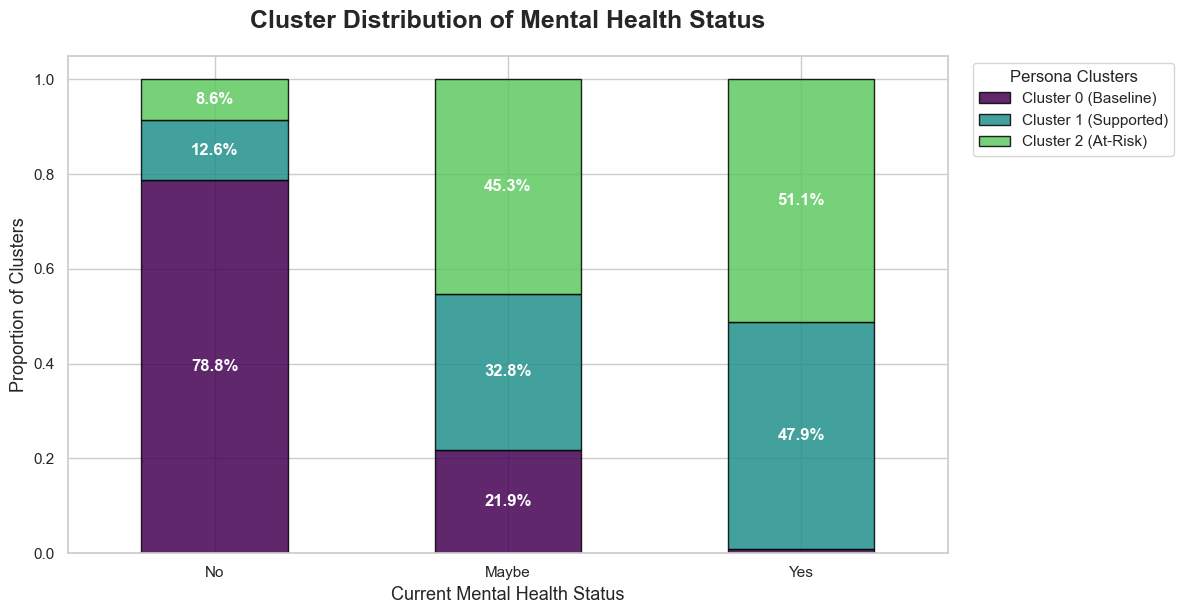

In [38]:
df_plot = df_final.copy()
df_plot['MH_Status'] = df_plot['curr_mh_disorder'].map(MH_MAPPING)

cross = pd.crosstab(df_plot['MH_Status'], df_plot['Cluster'], normalize='index')

order = ['No', 'Maybe', 'Yes']
cross = cross.reindex(order)
cluster_colors = ['#440154', '#21918c', '#5ec962'] 

ax = cross.plot(
    kind='bar', 
    stacked=True, 
    color=cluster_colors, 
    figsize=(12, 7), 
    alpha=0.85,
    edgecolor='black'
)

plt.title('Cluster Distribution of Mental Health Status', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Current Mental Health Status', fontsize=13)
plt.ylabel('Proportion of Clusters', fontsize=13)
plt.xticks(rotation=0, fontsize=11)

plt.legend(
    title='Persona Clusters', 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left',
    labels=['Cluster 0 (Baseline)', 'Cluster 1 (Supported)', 'Cluster 2 (At-Risk)']
)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0.05:
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, f'{height:.1%}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
save_fig("cluster_mh")
plt.show()